# Cohort 7.3 MS vs ELISA

### Imports and environment setup

- Date of run: 2025-06-06
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# import all functions from ../code/cohort_analysis_utils.py
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)

## Load MS data

In [4]:
df = pd.read_csv('../data/ms/cohort_7_3_MS_pg.csv', index_col='Protein.Names', header=0, sep='\t')

# Name harmonization
df.columns = list(df.columns[0:3]) + \
             [ c.replace('/users/pr/rawstream/2025NK011/mzml/', '')[0:len("2025NK011_EVCO_001")] for c in df.columns[3:] ]

# Convert to numeric 
df.iloc[:, 3:] = df.iloc[:, 3:].replace(0, np.nan)
df.iloc[:, 3:] = df.iloc[:, 3:].apply(pd.to_numeric, errors='coerce')

# Remove the first 3 columns, keeping only the protein names as columns
df = df.iloc[:, 3:]

# Keep a log2 transformation of the data
df = np.log2(df)

# Transpose, columns are now proteins and rows are samples, as in ELISA
df = df.T

######## NORMALIZATION TO THE MEDIAN ########
df = df.subtract(df.median(axis=1), axis=0)

In [5]:
df_metadata = pd.read_csv('../data/cohort_7.3_metadata.csv', index_col='id_ms', header=0, sep='\t')

df['Pathology'] = df_metadata['Pathology']
df['Endometrial_thickness'] = df_metadata['Endometrial_thickness']
df['sample'] = df_metadata['sample']

# Make the sample column the index and remove the actual index
df = df.set_index('sample')
df.index.name = None


In [6]:
MMK_BIOMARKERS = ["AGRIN_HUMAN", "MMP9_HUMAN", "TIMP2_HUMAN", 
                    "KPYM_HUMAN", "PERM_HUMAN", "MVP_HUMAN", "NGAL_HUMAN", "CLIC1_HUMAN", 
                    "PIGR_HUMAN"]


In [7]:
RATIOS_MS = []
for bmk in MMK_BIOMARKERS:
    for bmk2 in MMK_BIOMARKERS:
        if bmk != bmk2:
            ratio_name = f"{bmk.replace("_HUMAN","")}_{bmk2.replace("_HUMAN","")}"
            # Substracting because the biomarkers are already log2 transformed
            df[ratio_name] = df[bmk] - df[bmk2]
            RATIOS_MS.append(ratio_name)

In [8]:
df[RATIOS_MS].head()

Protein.Names,AGRIN_MMP9,AGRIN_TIMP2,AGRIN_KPYM,AGRIN_PERM,AGRIN_MVP,AGRIN_NGAL,AGRIN_CLIC1,AGRIN_PIGR,MMP9_AGRIN,MMP9_TIMP2,...,CLIC1_NGAL,CLIC1_PIGR,PIGR_AGRIN,PIGR_MMP9,PIGR_TIMP2,PIGR_KPYM,PIGR_PERM,PIGR_MVP,PIGR_NGAL,PIGR_CLIC1
001-0095,1.755416,0.213956,-3.885580,-1.766281,2.237704,-4.521169,-2.636221,-9.011588,-1.755416,-1.541461,...,-1.884948,-6.375367,9.011588,10.767004,9.225544,5.126008,7.245307,11.249292,4.490419,6.375367
010-0010,-2.857087,0.924273,-3.332686,-3.946652,2.079924,-7.003303,-1.195612,-8.159509,2.857087,3.781360,...,-5.807692,-6.963897,8.159509,5.302422,9.083781,4.826822,4.212856,10.239432,1.156206,6.963897
003-0153,-0.830414,-0.042750,-5.167512,-3.255330,-0.793341,-4.965350,-2.311040,-5.728125,0.830414,0.787664,...,-2.654311,-3.417085,5.728125,4.897711,5.685375,0.560613,2.472795,4.934785,0.762775,3.417085
001-0105,-2.736966,-0.456858,-5.736966,-3.603699,-1.164677,-6.408836,-3.193823,-8.913945,2.736966,2.280108,...,-3.215013,-5.720122,8.913945,6.176980,8.457088,3.176980,5.310246,7.749268,2.505109,5.720122
001-0120,-0.529024,-0.232043,-5.475625,0.131706,-0.581731,-5.775185,-2.740833,-8.082899,0.529024,0.296982,...,-3.034352,-5.342066,8.082899,7.553875,7.850857,2.607275,8.214605,7.501168,2.307714,5.342066


In [9]:
df_ms = df.copy()

## Load ELISA data

In [10]:
df = pd.read_csv('../data/cohort_7.3_20250527.csv', sep='\t', index_col=0, header=0)

df = utils.cols_as_category(df, {'Pathology':{'Benigna': 0, 'EC': 1}})

df.index.name = None


BIOMARKERS = ["MMP9", "KPYM", "AGRIN", "TIMP2", "MVP", "PERM", "CLIC1"]

for biomarker in BIOMARKERS:
    df[biomarker] =  pd.to_numeric(df[biomarker], errors='coerce')

# Create new columns with the ratios between the biomarkers
RATIOS_ELISA = []
for biomarker1 in BIOMARKERS:
    for biomarker2 in BIOMARKERS:
        if biomarker1 != biomarker2:
            df[f'{biomarker1}_{biomarker2}'] = df[f'{biomarker1}'] / df[f'{biomarker2}']
            # Make infinite values NaN
            df[f'{biomarker1}_{biomarker2}'] = df[f'{biomarker1}_{biomarker2}'].replace([np.inf, -np.inf], np.nan)
            # Apply log2 transformation to the ratios
            df[f'{biomarker1}_{biomarker2}'] = np.log2(df[f'{biomarker1}_{biomarker2}'])

            RATIOS_ELISA.append(f'{biomarker1}_{biomarker2}')

In [11]:
df_elisa = df.copy()

In [12]:
df_elisa[RATIOS_ELISA].head()

,MMP9_KPYM,MMP9_AGRIN,MMP9_TIMP2,MMP9_MVP,MMP9_PERM,MMP9_CLIC1,KPYM_MMP9,KPYM_AGRIN,KPYM_TIMP2,KPYM_MVP,...,PERM_AGRIN,PERM_TIMP2,PERM_MVP,PERM_CLIC1,CLIC1_MMP9,CLIC1_KPYM,CLIC1_AGRIN,CLIC1_TIMP2,CLIC1_MVP,CLIC1_PERM
020-0174,-4.649521,-2.142730,-0.312751,-3.627304,-2.100082,-5.673039,4.649521,2.506791,4.336770,1.022217,...,-0.042647,1.787331,-1.527222,-3.572957,5.673039,1.023518,3.530309,5.360288,2.045735,3.572957
001-0195,-4.837588,-2.994366,-2.430638,-2.972023,-4.505357,-4.909433,4.837588,1.843222,2.406950,1.865565,...,1.510991,2.074719,1.533334,-0.404076,4.909433,0.071845,1.915067,2.478795,1.937410,0.404076
020-0057,-3.854628,-1.112848,0.602804,-2.755170,-2.976649,-4.437043,3.854628,2.741781,4.457433,1.099459,...,1.863801,3.579453,0.221479,-1.460394,4.437043,0.582415,3.324196,5.039848,1.681873,1.460394
001-0025,NaN,-0.402859,1.383614,-1.170682,-3.701102,-3.145353,NaN,NaN,NaN,NaN,...,3.298242,5.084716,2.530419,0.555749,3.145353,NaN,2.742494,4.528967,1.974671,-0.555749
032-0016,-3.092851,-1.994024,0.280591,-1.137596,-3.382830,-4.415212,3.092851,1.098828,3.373442,1.955256,...,1.388806,3.663421,2.245234,-1.032382,4.415212,1.322361,2.421188,4.695803,3.277616,1.032382


In [13]:
# Compare RATIOS_MS and RATIOS_ELISA size and intersection
print(f"Number of MS ratios: {len(RATIOS_MS)}")
print(f"Number of ELISA ratios: {len(RATIOS_ELISA)}")
print(f"Intersection size: {len(set(RATIOS_MS).intersection(set(RATIOS_ELISA)))}")

Number of MS ratios: 72
Number of ELISA ratios: 42
Intersection size: 42


In [14]:
bloody_samples = list(set(df_ms.index) - set(df_ms.dropna(thresh=5000).index))


## Compute correlations

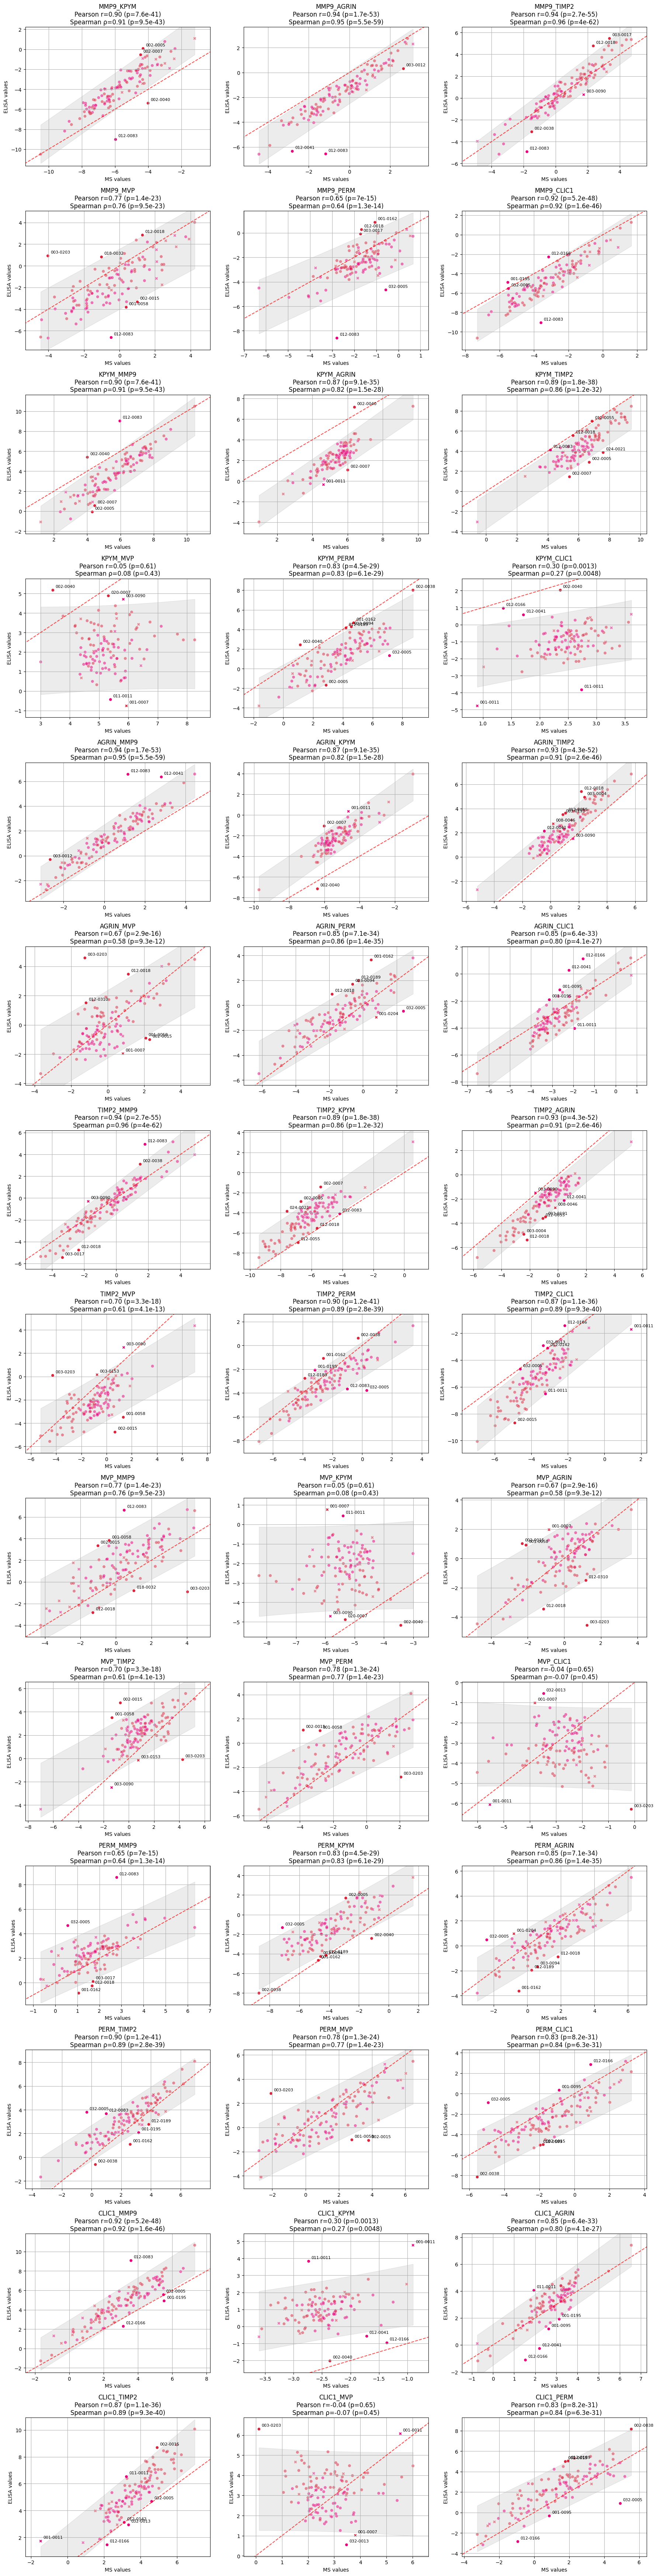

In [22]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, linregress
import matplotlib.pyplot as plt
import seaborn as sns

# Define Mimark's pink and red (replace with your actual hex codes if needed)
mimark_palette = {
    0: '#E6007A',  # Mimark pink
    1: '#D7263D',  # Mimark red
}

ratios_to_plot = [ratio for ratio in RATIOS_ELISA if ratio in df_ms.columns and ratio in df_elisa.columns]
n = len(ratios_to_plot)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
axes = axes.flatten()

# Dictionary to track outliers
outlier_summary = {}

for idx, ratio in enumerate(ratios_to_plot):
    s_ms = df_ms[ratio].copy()
    s_elisa = df_elisa[ratio].copy()

    # Remove rows with NaN as index or duplicate indices
    s_ms = s_ms[~s_ms.index.isna()]
    s_elisa = s_elisa[~s_elisa.index.isna()]
    s_ms = s_ms[~s_ms.index.duplicated(keep='first')]
    s_elisa = s_elisa[~s_elisa.index.duplicated(keep='first')]

    # Combine into a single DataFrame, aligning on index
    df_plot = pd.DataFrame({'MS': s_ms, 'ELISA': s_elisa}).dropna()

    # Add Pathology and Bloody columns
    df_plot['Pathology'] = df_ms.loc[df_plot.index, 'Pathology']
    df_plot['Bloody'] = df_plot.index.isin(bloody_samples)

    # Linear regression for confidence interval
    slope, intercept, r_value, p_value, std_err = linregress(df_plot['MS'], df_plot['ELISA'])
    y_pred = intercept + slope * df_plot['MS']
    residuals = df_plot['ELISA'] - y_pred
    dof = len(df_plot) - 2
    t_val = 1.96  # Approximate for 95% CI

    # Standard error of prediction
    s_err = np.sqrt(np.sum(residuals**2) / dof)
    x = df_plot['MS']
    mean_x = np.mean(x)
    n_points = len(x)
    pred_interval = t_val * s_err * np.sqrt(1 + 1/n_points + (x - mean_x)**2 / np.sum((x - mean_x)**2))

    # Find outliers: outside the prediction interval
    outliers = (df_plot['ELISA'] > y_pred + pred_interval) | (df_plot['ELISA'] < y_pred - pred_interval)
    df_plot['Outlier'] = outliers

    # Track outliers for summary
    for sample_id in df_plot.index[outliers]:
        if sample_id not in outlier_summary:
            outlier_summary[sample_id] = []
        outlier_summary[sample_id].append(ratio)

    ax = axes[idx]
    unique_pathologies = df_plot['Pathology'].unique()
    palette = {p: mimark_palette.get(p, '#333333') for p in unique_pathologies}

    # Plot non-outliers with alpha=0.05
    sns.scatterplot(
        x='MS', y='ELISA', data=df_plot[~df_plot['Outlier']], ax=ax,
        hue='Pathology',
        style='Bloody',
        markers={False: 'o', True: 'X'},
        palette=palette,
        legend=False,
        alpha=0.5
    )
    # Plot outliers with alpha=1
    sns.scatterplot(
        x='MS', y='ELISA', data=df_plot[df_plot['Outlier']], ax=ax,
        hue='Pathology',
        style='Bloody',
        markers={False: 'o', True: 'X'},
        palette=palette,
        legend=False,
        alpha=1
    )

    # Annotate only outliers
    for sample_id in df_plot.index[outliers]:
        ax.annotate(str(sample_id),
                    (df_plot.loc[sample_id, 'MS'], df_plot.loc[sample_id, 'ELISA']),
                    textcoords="offset points", xytext=(5,5), ha='left', fontsize=8, color='black')

    # Plot prediction interval area (almost transparent)
    x_sorted = np.sort(df_plot['MS'].values)
    y_pred_sorted = intercept + slope * x_sorted
    pred_interval_sorted = t_val * s_err * np.sqrt(1 + 1/n_points + (x_sorted - mean_x)**2 / np.sum((x - mean_x)**2))
    lower = y_pred_sorted - pred_interval_sorted
    upper = y_pred_sorted + pred_interval_sorted
    ax.fill_between(x_sorted, lower, upper, color='grey', alpha=0.15, zorder=0)

    # Dynamic axis limits with margin
    x_min, x_max = df_plot['MS'].min(), df_plot['MS'].max()
    y_min, y_max = df_plot['ELISA'].min(), df_plot['ELISA'].max()
    x_margin = (x_max - x_min) * 0.1 if x_max > x_min else 1
    y_margin = (y_max - y_min) * 0.1 if y_max > y_min else 1
    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

    # Add y=x line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', alpha=0.7)

    # Correlations
    pearson_corr, pearson_p = pearsonr(df_plot['MS'], df_plot['ELISA'])
    spearman_corr, spearman_p = spearmanr(df_plot['MS'], df_plot['ELISA'])
    ax.set_title(f'{ratio}\n'
                 f'Pearson r={pearson_corr:.2f} (p={pearson_p:.2g})\n'
                 f'Spearman ρ={spearman_corr:.2f} (p={spearman_p:.2g})')
    ax.set_xlabel('MS values')
    ax.set_ylabel('ELISA values')
    ax.grid()

# Hide unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [26]:
# Collect all unique biomarkers from the ratios
biomarkers = set()
for ratios in outlier_summary.values():
    for ratio in ratios:
        biomarkers.update(ratio.split('_'))
biomarkers = sorted(biomarkers)

# Build the summary table
rows = []
for sample_id, ratios in outlier_summary.items():
    marker = 'X' if sample_id in bloody_samples else 'O'
    biomarker_counts = {bm: 0 for bm in biomarkers}
    for ratio in ratios:
        for bm in ratio.split('_'):
            biomarker_counts[bm] += 0.5
    row = {'Sample': sample_id, 'Marker': marker, 'Total': len(ratios)/2}
    row.update(biomarker_counts)
    rows.append(row)

df_outlier_table = pd.DataFrame(rows)
df_outlier_table = df_outlier_table[['Marker', 'Sample', 'Total'] + biomarkers]
df_outlier_table = df_outlier_table.sort_values(by='Total', ascending=False)

print("\nOutlier summary table:")
print(df_outlier_table.to_string(index=False))


Outlier summary table:
Marker   Sample  Total  AGRIN  CLIC1  KPYM  MMP9  MVP  PERM  TIMP2
     O 012-0083    8.0    1.0    1.0   2.0   6.0  1.0   2.0    3.0
     O 012-0018    7.0    3.0    0.0   1.0   3.0  2.0   2.0    3.0
     O 032-0005    7.0    1.0    3.0   1.0   2.0  0.0   5.0    2.0
     O 002-0015    6.0    1.0    2.0   0.0   1.0  4.0   2.0    2.0
     O 003-0203    5.0    1.0    1.0   0.0   1.0  5.0   1.0    1.0
     O 002-0040    5.0    1.0    1.0   5.0   1.0  1.0   1.0    0.0
     O 012-0166    5.0    1.0    5.0   1.0   1.0  0.0   1.0    1.0
     X 001-0011    4.0    1.0    3.0   2.0   0.0  1.0   0.0    1.0
     O 001-0162    4.0    1.0    0.0   1.0   1.0  0.0   4.0    1.0
     O 002-0038    4.0    0.0    1.0   1.0   1.0  0.0   3.0    2.0
     O 012-0041    4.0    3.0    2.0   1.0   1.0  0.0   0.0    1.0
     O 012-0189    4.0    1.0    1.0   1.0   0.0  0.0   4.0    1.0
     O 011-0011    4.0    1.0    3.0   2.0   0.0  1.0   0.0    1.0
     X 003-0090    4.0    1.0    0.0  